[brute] it=   0  residual=2.016e+00
[brute] it=  10  residual=4.342e-02
[brute] it=  20  residual=2.705e-02
[brute] it=  30  residual=1.709e-02
[brute] it=  40  residual=1.065e-02
[brute] it=  50  residual=6.818e-03
[brute] it=  60  residual=4.390e-03
[brute] it=  70  residual=2.868e-03
[brute] it=  80  residual=2.020e-03
[brute] it=  90  residual=1.492e-03
[brute] it= 100  residual=1.155e-03
[dvqe ] it=   0  residual=2.034e+00
[dvqe ] it=  10  residual=3.795e-02
[dvqe ] it=  20  residual=2.412e-02
[dvqe ] it=  30  residual=1.499e-02
[dvqe ] it=  40  residual=9.740e-03
[dvqe ] it=  50  residual=6.487e-03
[dvqe ] it=  60  residual=4.395e-03
[dvqe ] it=  70  residual=3.045e-03
[dvqe ] it=  80  residual=2.162e-03
[dvqe ] it=  90  residual=1.566e-03
[dvqe ] it= 100  residual=1.167e-03


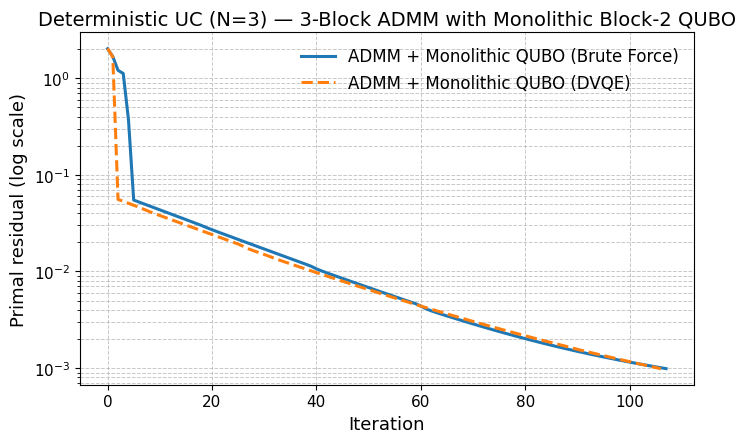

Saved figure: admm_uc_monolithic_residuals.jpg


In [2]:
# ===========================================
# Deterministic UC (N=3) via 3-Block ADMM
# Block-2: MONOLITHIC QUBO per time slice (y,u,v together)
# - Run 1: Brute Force QUBO
# - Run 2: DVQE QUBO
# Output: publication-quality plot comparing residuals, saved as JPG
# ===========================================

import numpy as np
import cvxpy as cp
import math
import matplotlib.pyplot as plt
from itertools import product

# Optional (only needed for the DVQE run)
try:
    from raiselab import DVQE
    HAS_DVQE = True
except Exception:
    HAS_DVQE = False

# -------------------------------
# Global Config
# -------------------------------
N = 3              # units
T = 6              # periods

# Costs
A = np.array([500, 600, 450], dtype=float)     # no-load
B = np.array([20.0, 25.0, 18.0], dtype=float)
C = np.array([0.002, 0.0015, 0.0025], dtype=float)
S = np.array([200, 200, 250], dtype=float)     # startup
H = np.array([0,   0,   0  ], dtype=float)     # shutdown

# Capacities
Pmin = np.array([10, 20, 15], dtype=float)
Pmax = np.array([60, 80, 70], dtype=float)

# Ramps (per period)
RU = np.array([30, 30, 25], dtype=float)
RD = np.array([30, 30, 25], dtype=float)
SU = np.array([40, 40, 35], dtype=float)
SD = np.array([40, 40, 35], dtype=float)

# Min up/down (periods)
Umin = np.array([2, 2, 3], dtype=int)
Dmin = np.array([2, 2, 2], dtype=int)

# Demand & reserves
L = np.array([80, 90, 100, 95, 85, 75], dtype=float)
R_up_req = np.array([8, 8, 10, 10, 8, 6], dtype=float)
R_dn_req = np.array([6, 6, 8,  8, 6, 6], dtype=float)
delta_tau = 1.0  # 1 period

# ADMM Hyperparameters
rho_y = rho_u = rho_v = 7.0e5
beta_y = beta_u = beta_v = 7.0e6
epsilon = 1e-3
max_iter = 3000

# Utility
ACCEPT_TOL = 1e-12
Y_THRESHOLD = 0.5

# DVQE (only used in the DVQE run)
dvqe_mode = "distributed"   # or "monolithic"
dvqe_depth = 2
dvqe_lr = 0.1
dvqe_max_iters = 100
qpu_qubit_config = [3, 3, 3,3,3]   # per-time: 3N bits -> this is ignored in some impls; keep for compatibility

rng = np.random.default_rng(7)

# ---------------------------------
# Helper: brute-force solver (monolithic)
# ---------------------------------
def solve_qubo_bruteforce(Q, q_linear):
    Q = np.asarray(Q, dtype=float)
    q = np.asarray(q_linear, dtype=float).ravel()
    n = q.size
    if Q.shape != (n, n):
        raise ValueError(f"Q must be ({n},{n}); got {Q.shape}")
    # Symmetrize
    Q = 0.5 * (Q + Q.T)
    best_z, best_cost = None, float("inf")
    for cand in product([0, 1], repeat=n):
        z = np.fromiter(cand, dtype=float, count=n)
        cost = z @ Q @ z + q @ z
        if cost < best_cost:
            best_cost = cost
            best_z = z.astype(int)
    return best_z, best_cost

# ---------------------------------
# Diagnostics (for prints if needed)
# ---------------------------------
def capacity_violations(pv, yv):
    below = np.maximum(0.0, (Pmin[:, None] * yv) - pv)
    above = np.maximum(0.0, pv - (Pmax[:, None] * yv))
    return float(np.max(below)), float(np.max(above))

def power_balance_mismatch(pv):
    mis = np.abs(np.sum(pv, axis=0) - L)
    return float(np.max(mis))

# ---------------------------------
# Core ADMM Runner
#   solver in {"brute", "dvqe"}
#   Block-2: single monolithic QUBO per time over [z_y; z_u; z_v] (length 3N)
# ---------------------------------
def run_admm_monolithic(solver="brute"):
    # Initial p0 in [20,30] and y0 inferred
    p0 = np.ones(N)* 20
    y0 = (p0 > 0.0).astype(int)

    # Relaxed primals (Block-1)
    y = np.ones((N, T)) * 0.5
    u = np.zeros((N, T))
    v = np.zeros((N, T))
    p = np.tile(L / max(N, 1), (N, 1))
    r_up = np.zeros((N, T))
    r_dn = np.zeros((N, T))

    # Auxiliaries & slacks
    z_y = np.zeros((N, T), dtype=int)
    z_u = np.zeros((N, T), dtype=int)
    z_v = np.zeros((N, T), dtype=int)
    s_y = np.zeros((N, T))
    s_u = np.zeros((N, T))
    s_v = np.zeros((N, T))

    # Duals
    lam_y = np.zeros((N, T))
    lam_u = np.zeros((N, T))
    lam_v = np.zeros((N, T))

    residuals = []

    for it in range(max_iter):
        # ========= Block 1: Classical QP =========
        yi  = cp.Variable((N, T))
        ui  = cp.Variable((N, T))
        vi  = cp.Variable((N, T))
        pi  = cp.Variable((N, T))
        rup = cp.Variable((N, T), nonneg=True)
        rdn = cp.Variable((N, T), nonneg=True)

        econ = (
            cp.sum(cp.multiply(A[:, None], yi)) +
            cp.sum(cp.multiply(B[:, None], pi)) +
            cp.sum(cp.multiply(C[:, None], cp.square(pi))) +
            cp.sum(cp.multiply(S[:, None], ui)) +
            cp.sum(cp.multiply(H[:, None], vi))
        )
        pen_y = cp.sum(cp.multiply(lam_y, yi - z_y + s_y)) + (rho_y / 2) * cp.sum_squares(yi - z_y + s_y)
        pen_u = cp.sum(cp.multiply(lam_u, ui - z_u + s_u)) + (rho_u / 2) * cp.sum_squares(ui - z_u + s_u)
        pen_v = cp.sum(cp.multiply(lam_v, vi - z_v + s_v)) + (rho_v / 2) * cp.sum_squares(vi - z_v + s_v)
        objective = cp.Minimize(econ + pen_y + pen_u + pen_v)

        cons = []
        # Domains
        cons += [yi >= 0, yi <= 1, ui >= 0, ui <= 1, vi >= 0, vi <= 1]
        cons += [pi >= 0]
        # Power balance
        for t in range(T):
            cons += [cp.sum(pi[:, t]) == L[t]]
        # Capacity bounds
        cons += [pi >= cp.multiply(Pmin[:, None], yi)]
        cons += [pi <= cp.multiply(Pmax[:, None], yi)]
        # Transitions & no-simultaneous
        cons += [yi[:, 0] - y0 == ui[:, 0] - vi[:, 0]]
        cons += [ui[:, 0] + vi[:, 0] <= 1]
        for t in range(1, T):
            cons += [yi[:, t] - yi[:, t - 1] == ui[:, t] - vi[:, t]]
            cons += [ui[:, t] + vi[:, t] <= 1]
        # Min up/down windows
        for i in range(N):
            Ui, Di = int(Umin[i]), int(Dmin[i])
            for t in range(T):
                k_up = max(0, t - Ui + 1)
                k_dn = max(0, t - Di + 1)
                cons += [cp.sum(ui[i, k_up:t + 1]) <= yi[i, t]]
                cons += [cp.sum(vi[i, k_dn:t + 1]) <= 1 - yi[i, t]]
        # Ramping with SU/SD
        for i in range(N):
            cons += [pi[i, 0] - p0[i] <= RU[i] * y0[i] + SU[i] * ui[i, 0]]
            cons += [p0[i] - pi[i, 0] <= RD[i] * yi[i, 0] + SD[i] * vi[i, 0]]
            for t in range(1, T):
                cons += [pi[i, t] - pi[i, t - 1] <= RU[i] * yi[i, t - 1] + SU[i] * ui[i, t]]
                cons += [pi[i, t - 1] - pi[i, t] <= RD[i] * yi[i, t] + SD[i] * vi[i, t]]
        # Reserves headroom/footroom + deliverability
        cons += [rup <= cp.multiply(Pmax[:, None], yi) - pi]
        cons += [rdn <= pi - cp.multiply(Pmin[:, None], yi)]
        cons += [rup <= RU[:, None] * delta_tau]
        cons += [rdn <= RD[:, None] * delta_tau]
        # System reserve requirements
        for t in range(T):
            cons += [cp.sum(rup[:, t]) >= R_up_req[t]]
            cons += [cp.sum(rdn[:, t]) >= R_dn_req[t]]

        # Warm-start
        yi.value, ui.value, vi.value = y, u, v
        pi.value, rup.value, rdn.value = p, r_up, r_dn

        # Solve Block-1
        prob = cp.Problem(objective, cons)
        installed = set(cp.installed_solvers())
        status = "unknown"
        if "OSQP" in installed:
            prob.solve(solver=cp.OSQP, eps_abs=1e-7, eps_rel=1e-7,
                       max_iter=800000, polish=True, warm_start=True, verbose=False)
            status = prob.status
        if status not in ("optimal", "optimal_inaccurate") and "SCS" in installed:
            prob.solve(solver=cp.SCS, eps=5e-7, max_iters=1_200_000,
                       warm_start=True, verbose=False)
            status = prob.status

        # Extract values
        y   = yi.value
        u   = ui.value
        v   = vi.value
        p   = pi.value
        r_up = rup.value
        r_dn = rdn.value

        # ========= Block 2: Monolithic QUBO per time =========
        # z_t ∈ {0,1}^{3N} : [z_y; z_u; z_v]
        z_y_prev, z_u_prev, z_v_prev = z_y.copy(), z_u.copy(), z_v.copy()
        for t in range(T):
            qy = -(lam_y[:, t] + rho_y * (y[:, t] + s_y[:, t])) + 0.5 * rho_y
            qu = -(lam_u[:, t] + rho_u * (u[:, t] + s_u[:, t])) + 0.5 * rho_u
            qv = -(lam_v[:, t] + rho_v * (v[:, t] + s_v[:, t])) + 0.5 * rho_v

            q = np.concatenate([qy, qu, qv])          # 3N linear terms
            Q = np.zeros((3 * N, 3 * N), dtype=float) # monolithic (no couplings here)

            # Current incumbent combined
            z_prev = np.concatenate([z_y_prev[:, t], z_u_prev[:, t], z_v_prev[:, t]])

            if solver == "brute":
                z_t, _ = solve_qubo_bruteforce(Q, q)
            elif solver == "dvqe":
                if not HAS_DVQE:
                    raise RuntimeError("DVQE not available. Please install/enable raiselab.DVQE.")
                z_t, _, _ = DVQE(mode=dvqe_mode, Q=Q, q_linear=q, init_type=2,
                                 depth=dvqe_depth, lr=dvqe_lr, max_iters=dvqe_max_iters,
                                 qpu_qubit_config=qpu_qubit_config, rel_tol=1e-6)
            else:
                raise ValueError("solver must be 'brute' or 'dvqe'.")

            z_t = (np.asarray(z_t).ravel() > 0.5).astype(int)

            # Accept-if-better w.r.t. linear objective (Q is zero here)
            if float(q @ z_t) + ACCEPT_TOL < float(q @ z_prev):
                z_y[:, t] = z_t[0:N]
                z_u[:, t] = z_t[N:2 * N]
                z_v[:, t] = z_t[2 * N:3 * N]
            else:
                z_y[:, t] = z_y_prev[:, t]
                z_u[:, t] = z_u_prev[:, t]
                z_v[:, t] = z_v_prev[:, t]

        # ========= Block 3: Prox slacks (nonnegativity projection) =========
        s_y = -(lam_y + rho_y * (y - z_y)) / (beta_y + rho_y)
        s_u = -(lam_u + rho_u * (u - z_u)) / (beta_u + rho_u)
        s_v = -(lam_v + rho_v * (v - z_v)) / (beta_v + rho_v)
        s_y = np.maximum(0.0, s_y)
        s_u = np.maximum(0.0, s_u)
        s_v = np.maximum(0.0, s_v)

        # ========= Dual Updates =========
        lam_y = lam_y + 0.5 * rho_y * (y - z_y + s_y)
        lam_u = lam_u + 0.5 * rho_u * (u - z_u + s_u)
        lam_v = lam_v + 0.5 * rho_v * (v - z_v + s_v)

        # ========= Residual & Stop =========
        res = math.sqrt(
            np.linalg.norm((y - z_y + s_y).ravel())**2 +
            np.linalg.norm((u - z_u + s_u).ravel())**2 +
            np.linalg.norm((v - z_v + s_v).ravel())**2
        )
        residuals.append(res)
        if (it % 10) == 0:
            print(f"[{solver:5s}] it={it:4d}  residual={res:.3e}")
        if res < epsilon:
            break

    return residuals

# -------------------------------
# Run both variants
# -------------------------------
res_brute = run_admm_monolithic(solver="brute")
res_dvqe = run_admm_monolithic(solver="dvqe") if HAS_DVQE else None

# -------------------------------
# Plot (publication style) & Save
# -------------------------------
plt.rcParams.update({
    "font.size": 12,           # base font size
    "axes.labelsize": 13,
    "axes.titlesize": 14,
    "legend.fontsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11
})

plt.figure(figsize=(7.2, 4.6))
# Avoid markers for a clean publication curve; thicker lines
plt.semilogy(res_brute, linewidth=2.2, label="ADMM + Monolithic QUBO (Brute Force)")
if res_dvqe is not None:
    plt.semilogy(res_dvqe, linewidth=2.2, linestyle="--",
                 label="ADMM + Monolithic QUBO (DVQE)")
else:
    plt.semilogy([], [], label="DVQE not available", alpha=0.0)  # keep legend alignment if needed

plt.grid(True, which="both", linestyle="--", linewidth=0.7, alpha=0.7)
plt.xlabel("Iteration")
plt.ylabel("Primal residual (log scale)")
plt.title("Deterministic UC (N=3) — 3-Block ADMM with Monolithic Block-2 QUBO")
plt.tight_layout()
plt.legend(frameon=False)
plt.savefig("admm_uc_monolithic_residuals.jpg", dpi=300)
plt.show()

print("Saved figure: admm_uc_monolithic_residuals.jpg")
